Conversion from CellRank pipeline
=================================
The aim of this notebook is to convert resulting analysis from CellRank into a principal tree that can be used by scFates

CellRank aims at identifying fate potentials by considering single cell dynamics as a Markov process (see [Lange et al., biorxiv, 2021](https://www.biorxiv.org/content/10.1101/2020.10.19.345983v2)). This is a great tool for finding the macrostates such as the "tips" of our trajectories, thanks to its powerful probabilistic approach. Here we propose to extend it by converting the fate probabilities into a principal tree, allowing easier interpretation of what is happening "in between" (early biases, bifurcations).

## Setting up environment modules and basic settings

### Generating the environment

The following needs to be run in the command-line

```bash
conda create -n scFates -c conda-forge -c r python=3.8 r-mgcv rpy2=3.4.2 -y
conda activate scFates

# Install new jupyter server
conda install -c conda-forge jupyter

# Or add to an existing jupyter server
conda install -c conda-forge ipykernel
python -m ipykernel install --user --name scFates --display-name "scFates"

# Install scFates
pip install scFates
```

### Required additional packages

In [1]:
import sys
!{sys.executable} -m pip -q install scvelo cellrank

### Loading modules and settings

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [3]:
import warnings
warnings.simplefilter("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = FutureWarning)

## Reproduction of CellRank notebook

Here we run a compressed version of the CellRank [notebook](https://nbviewer.org/github/theislab/cellrank_reproducibility/blob/master/notebooks/fig_2_pancreas_main/ML_2021-09-21_fig_2_and_3_pancreas_main.ipynb) which reproduces figure 2 of their paper.

In [4]:
adata = cr.datasets.pancreas()
adata.var_names.name=None
adata.raw = adata # We want to keep all the genes for testing on the resulting tree 
scv.pp.filter_genes(adata,min_shared_counts=20)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

scv.tl.latent_time(adata)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 20/88 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points'

Defaulting to `mode='monte_carlo'` and `n_samples=1000`
Computing transition matrix based on logits using `'monte_carlo'` mode


/tmp/ipykernel_1233105/1773602998.py:7: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = cr.tl.transition_matrix(adata,


Estimating `softmax_scale` using `'deterministic'` mode


100%|██████████| 2531/2531 [00:05<00:00, 429.55cell/s] 

Setting `softmax_scale=3.7951`



100%|██████████| 2531/2531 [00:20<00:00, 122.11sample/s]

    Finish (0:00:27)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 9, 15, 17]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)
Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:18)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities
Defaulting to `'gmres'` solver.


100%|██████████| 4/4 [00:00<00:00, 38.09/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


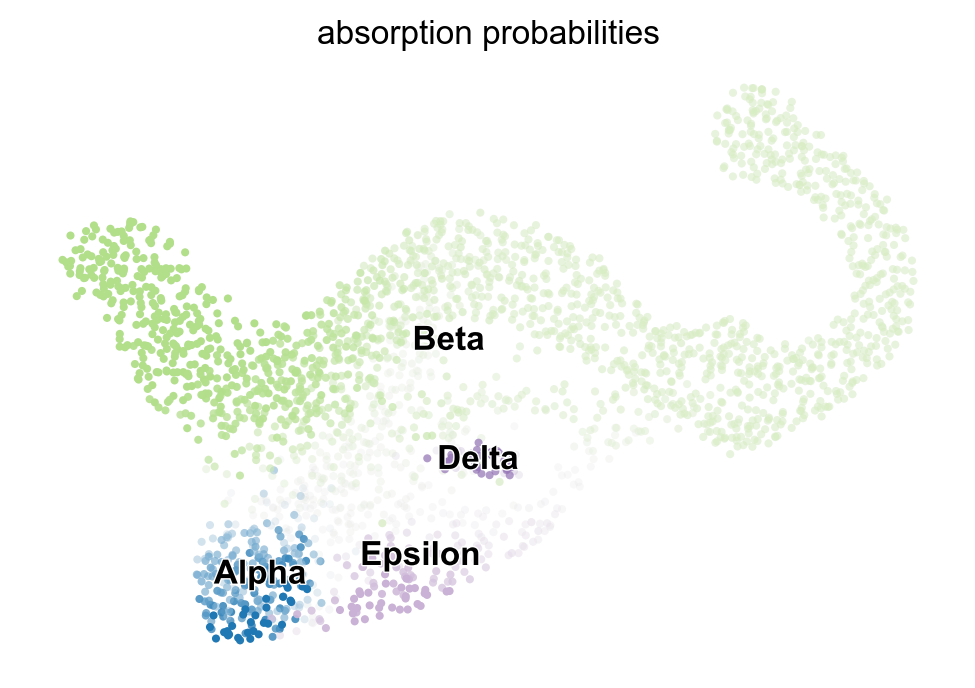

In [5]:
from cellrank.tl.estimators import GPCCA
weight_connectivities=0.2
mode="stochastic" 
n_jobs=40
softmax_scale=None

kernel = cr.tl.transition_matrix(adata, 
                                 weight_connectivities=weight_connectivities, 
                                 mode=mode, 
                                 n_jobs=n_jobs, 
                                 softmax_scale=softmax_scale)
g_fwd = GPCCA(kernel)
g_fwd.compute_schur(n_components=20)
n_states = 12
g_fwd.compute_macrostates(cluster_key='clusters', n_states=n_states)

g_fwd.set_terminal_states_from_macrostates(names=['Alpha', 'Beta', 'Epsilon', 'Delta'])
g_fwd.compute_absorption_probabilities()
cr.pl.lineages(adata)

## Converting Cellrank output into a principal tree

In [6]:
warnings.simplefilter("ignore", category = DeprecationWarning)
import scFates as scf

In [7]:
scf.tl.cellrank_to_tree(adata,time="latent_time",Nodes=300,seed=1)

Converting CellRank results to a principal tree --> with .obsm['X_fates'], created by combining:
    .obsm['X_fate_simplex_fwd'] (from cr.pl.circular_projection) and adata.obs['latent_time']

Solving TSP for `4` states
inferring a principal tree inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.1, lambda = 100, metric = euclidean
    fitting:  54%|█████▍    | 27/50 [00:02<00:02,  9.58it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.

finished (0:00:02)     .obsm['X_fates'] representation used for fitting the tree.
    .uns['graph']['pp_info'].time has been updated with latent_time
    .uns['graph']['pp_seg'].d has been updated with latent_time


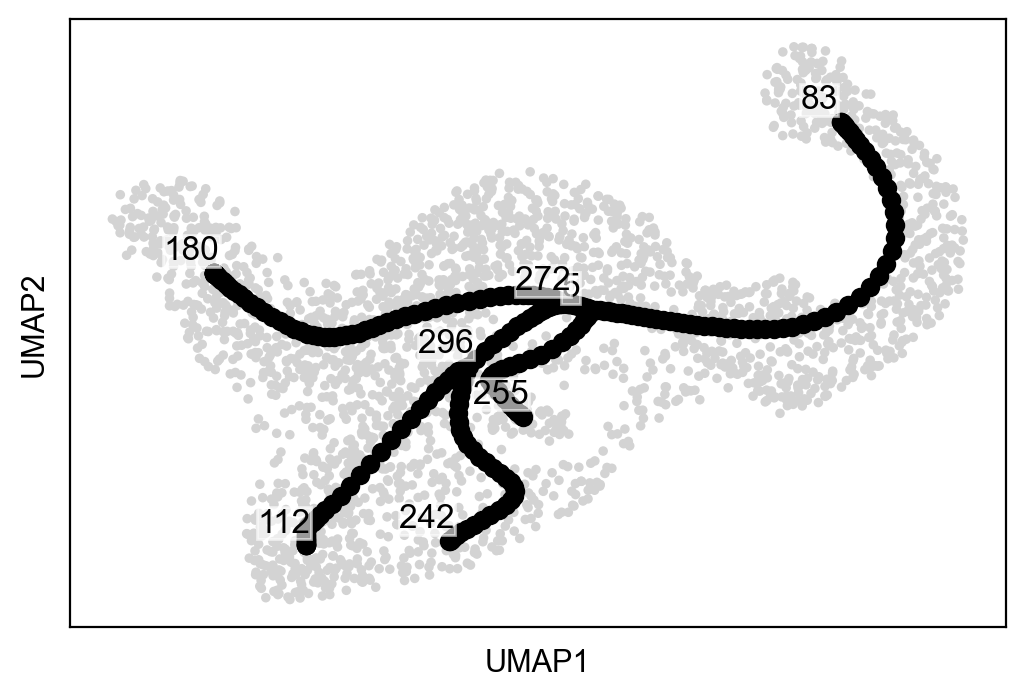

In [8]:
scf.pl.graph(adata)

In [9]:
scf.tl.root(adata,83)
scf.tl.pseudotime(adata,n_jobs=20,n_map=100,seed=42)

node 83 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    mappings: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s]
    finished (0:00:38) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


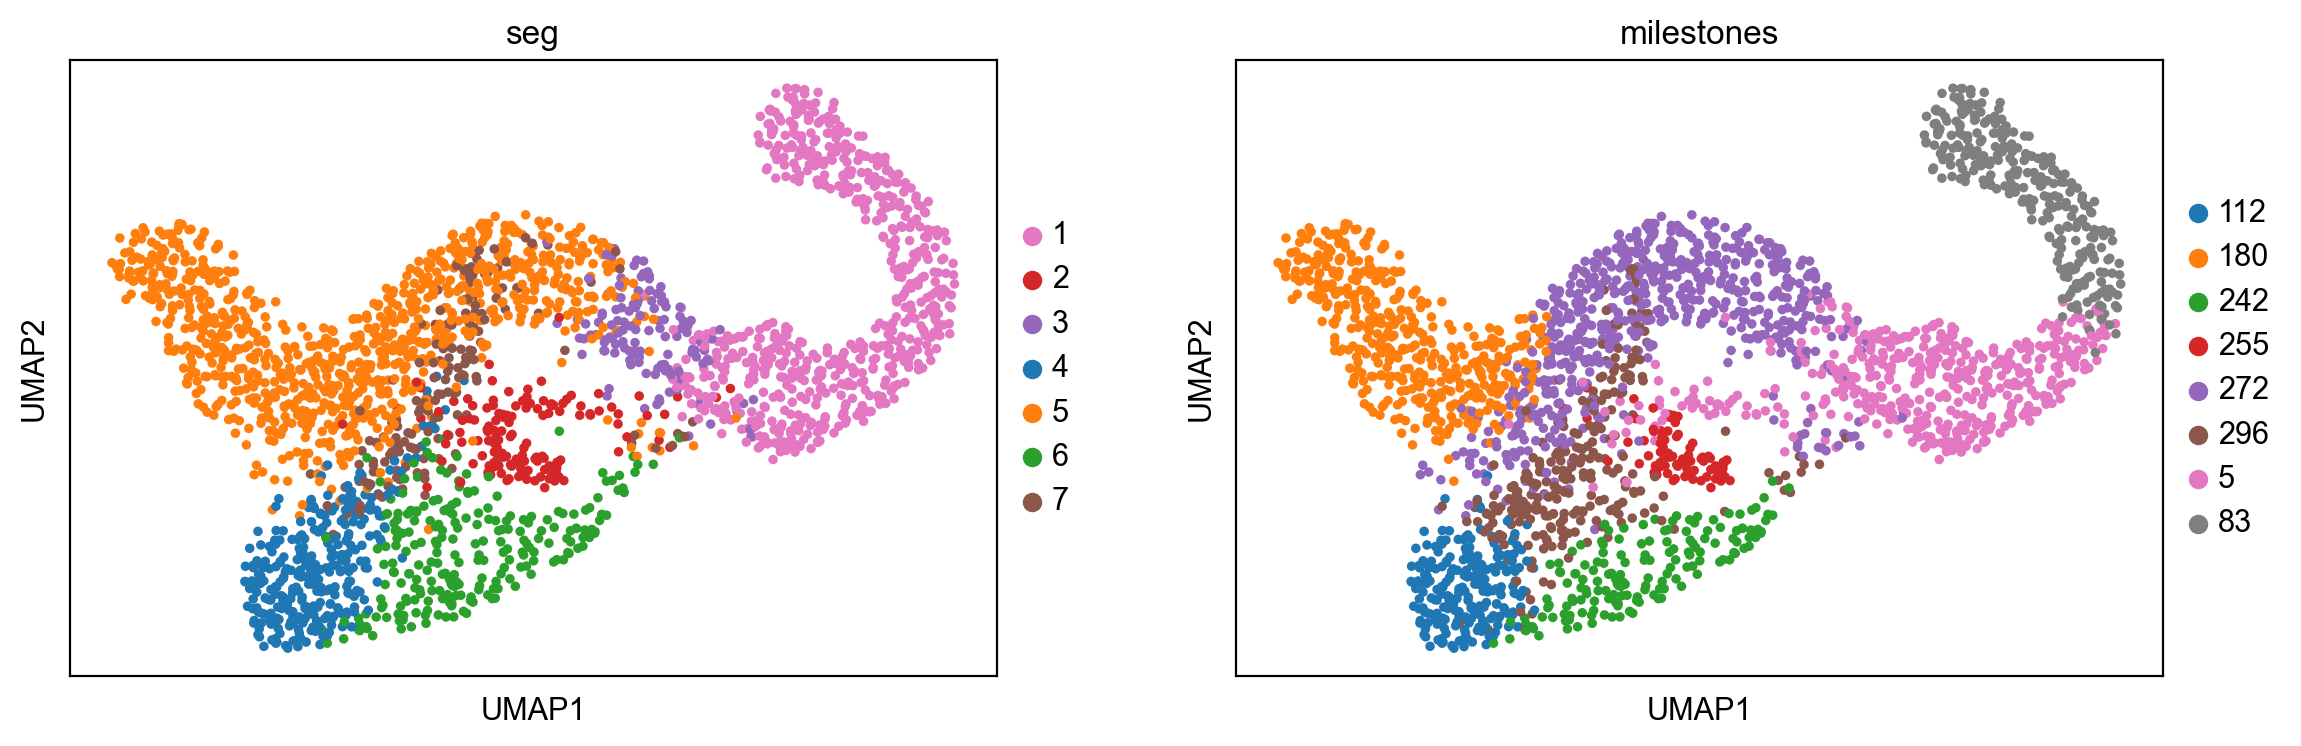

In [10]:
sc.pl.umap(adata,color=["seg","milestones"])

In [11]:
# to avoid overlapping of labels, we set some intermediate states to empty strings of varying length
dct={"112":"Alpha","180":"Beta","5":"Ngn3 high EP","242":"Epsilon","255":"Delta","272":"  ","296":" ","83":"Ngn3 low EP"}

In [12]:
scf.tl.rename_milestones(adata,dct)

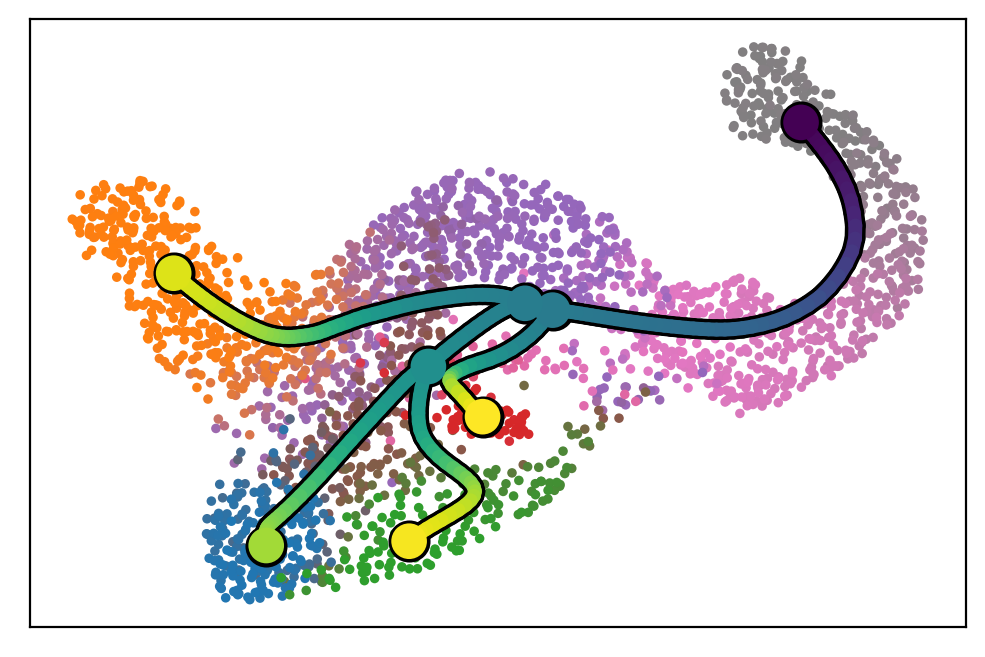

In [13]:
scf.pl.trajectory(adata,color_cells="milestones")

In [14]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]
    finished (0:00:01) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


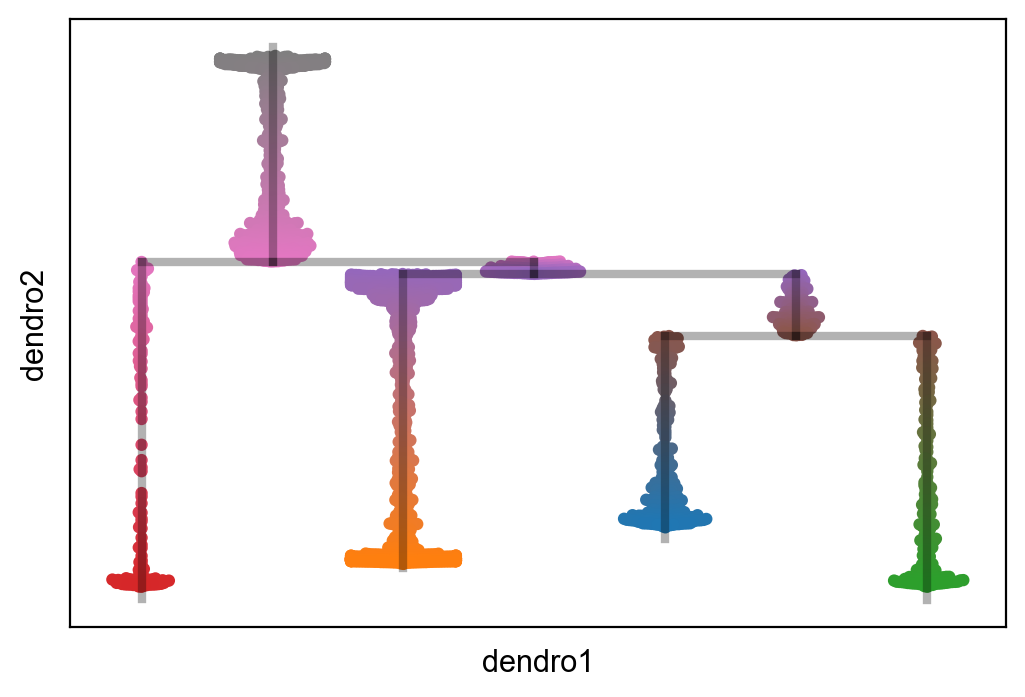

In [15]:
scf.pl.dendrogram(adata,color_milestones=True)

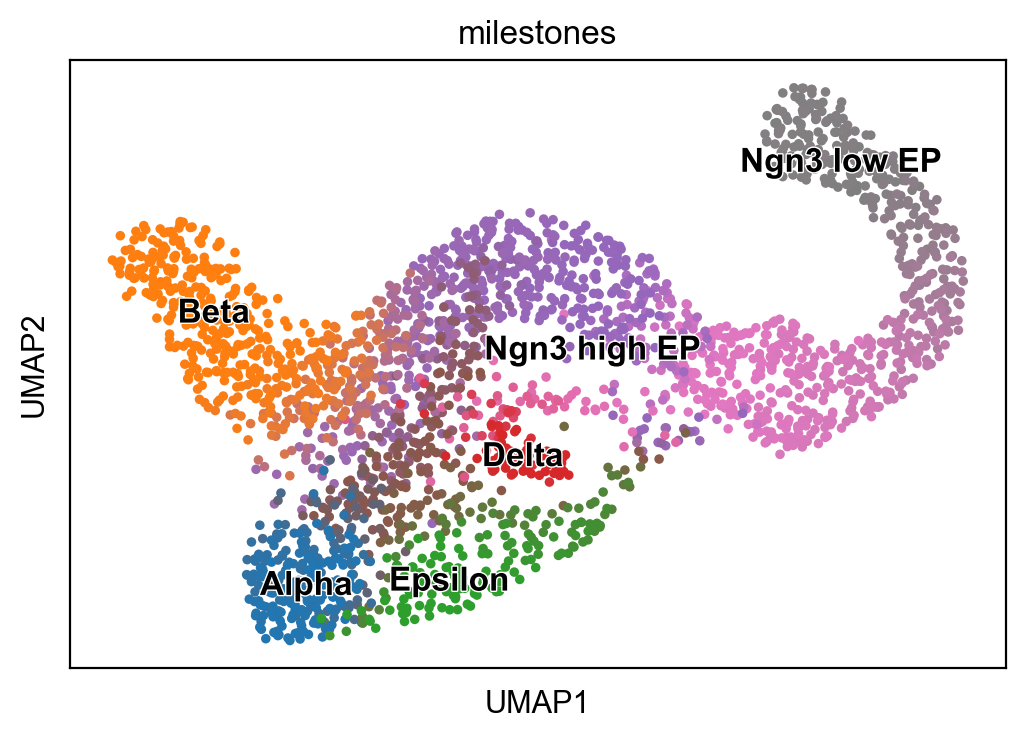

In [16]:
scf.pl.milestones(adata,annotate=True)

## How the conversion is performed

<div class="alert alert-info">
    
**Note**

The following section is not needed for your own analysis pipeline, it is rather an explanation of what is going on when running the function `scf.tl.cellrank_to_tree`

</div>

From the scvelo/CellRank pipeline, we used the latent time estimate:

In [17]:
scv.tl.latent_time(adata)

computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


And a projection of the fate probabilities:

Solving TSP for `4` states


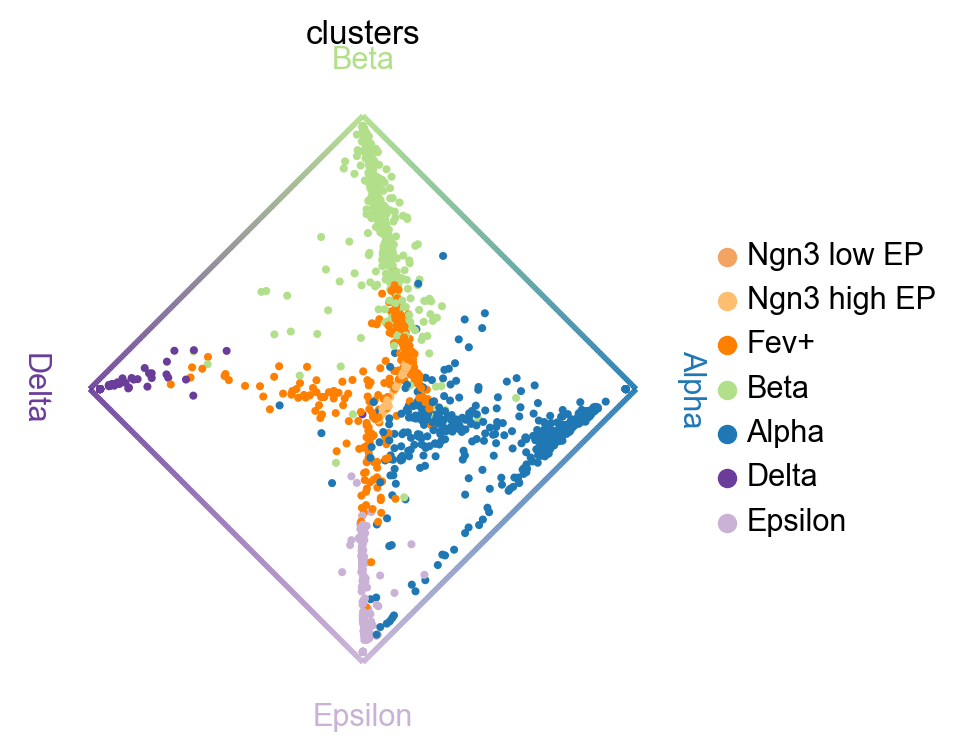

In [18]:
cr.pl.circular_projection(adata,"clusters",legend_loc="right")

This projection generated by`cr.pl.circular_projection` can be found under: 

In [19]:
adata.obsm["X_fate_simplex_fwd"]

array([[ 0.17996252,  0.13099097],
       [ 0.27331319, -0.11478642],
       [ 0.17542952,  0.09987978],
       ...,
       [ 0.15714817,  0.19592445],
       [ 0.83724649, -0.12325167],
       [ 0.00368501, -0.80083918]])

if we add a third dimension using our latent time or any pseudotime measurement, we obtain the following

In [20]:
adata.obsm["X_fates"]=np.concatenate([adata.obsm["X_fate_simplex_fwd"],
                                          adata.obs["latent_time"].values.reshape(-1,1)],axis=1)

In [21]:
adata.obsm["X_fates"]

array([[ 0.17996252,  0.13099097,  0.8600946 ],
       [ 0.27331319, -0.11478642,  0.88931465],
       [ 0.17542952,  0.09987978,  0.65183399],
       ...,
       [ 0.15714817,  0.19592445,  0.82558667],
       [ 0.83724649, -0.12325167,  0.85034744],
       [ 0.00368501, -0.80083918,  0.83946749]])

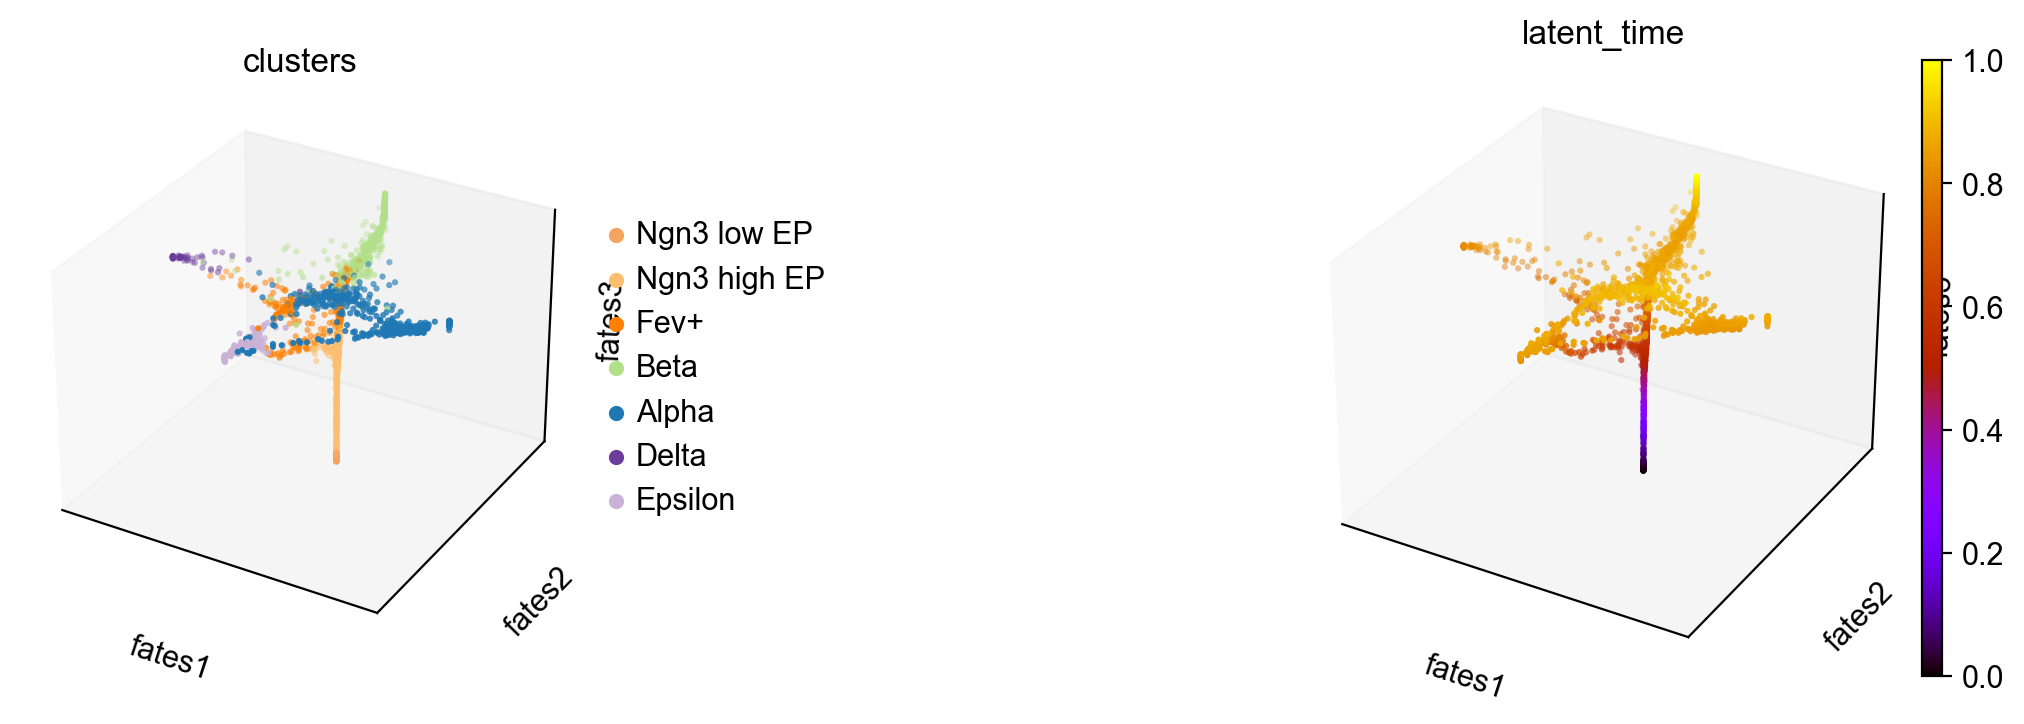

In [22]:
sc.pl.embedding(adata,basis="fates",projection="3d",color=["clusters","latent_time"],cmap="gnuplot")

We then fitted a principal tree in this 3d space! Given that each dimension is between 0 and 1, scFates should be able to easily capture all the tips without having to tweak the parameters. 

/home/lfaure/miniconda3/envs/scFates/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


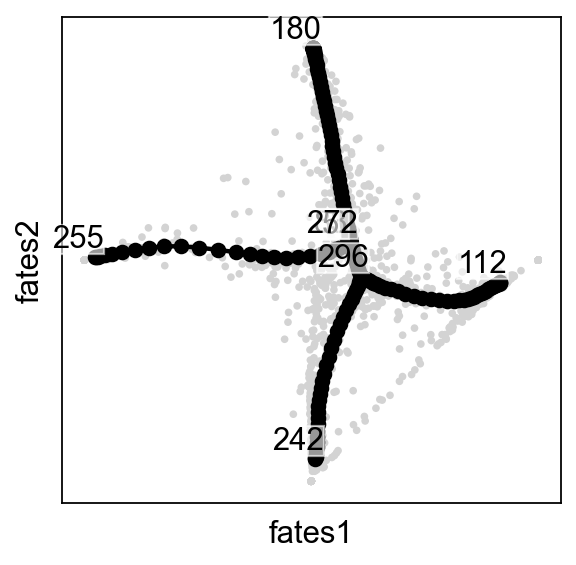

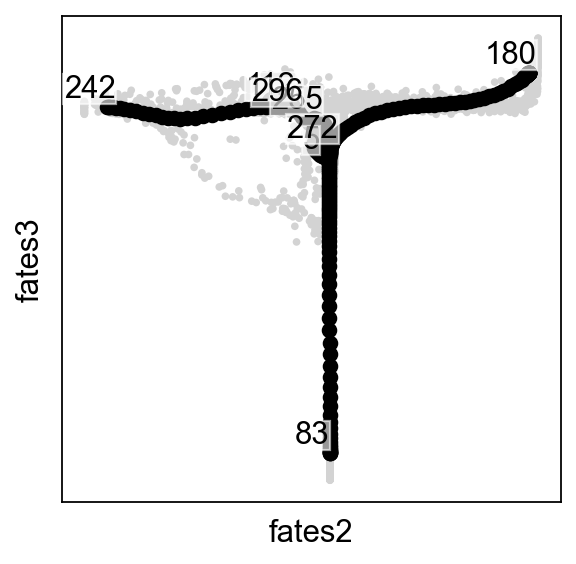

In [23]:
sc.set_figure_params()
scf.pl.graph(adata,basis="fates")
scf.pl.graph(adata,basis="fates",dimensions=[1,2])

What about the case of two terminal states only? 

No simplex representation can be generated, in such case, one column from `adata.obsm['to_terminal_states']` is used as 2d representation to be combined with the time estimate. 

What about multiple initial states? 

We could combine `adata.obsm['X_fate_simplex_fwd']` or `adata.obsm['to_terminal_states']` with `adata.obsm['X_fate_simplex_bwd']` or `adata.obsm['from_intial_states']` into a 4d representation, this will be implemented and tested in a future version.

## Downstream analysis

### Test and fitting associated genes

In [24]:
adata=adata.raw.to_adata()

In [25]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

In [26]:
scf.tl.test_association(adata,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|██████████| 14939/14939 [02:34<00:00, 96.67it/s]
    found 1545 significant features (0:02:34) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


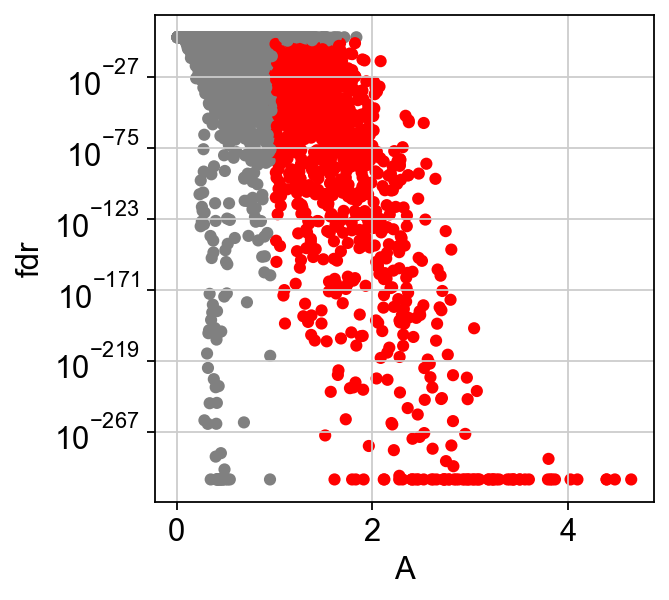

In [27]:
scf.pl.test_association(adata)

In [28]:
scf.tl.fit(adata,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 1545/1545 [00:45<00:00, 34.11it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:46) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


### Identification of branch specific genes

In [29]:
root='Ngn3 low EP'
miles=['Alpha','Epsilon','Beta','Delta']

In [30]:
scf.tl.test_fork(adata,root_milestone=root,milestones=miles,n_jobs=20,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 1545/1545 [00:25<00:00, 61.35it/s]
    test for upregulation for each leave vs root
    upreg Delta: 100%|██████████| 285/285 [00:00<00:00, 882.93it/s]
    finished (0:00:28) --> added 
    .uns['Ngn3 low EP->Alpha<>Epsilon<>Beta<>Delta']['fork'], DataFrame with fork test results.


In [31]:
scf.tl.branch_specific(adata,root_milestone=root,milestones=miles,effect=.3)

    branch specific features: Alpha: 53, Beta: 44, Delta: 8, Epsilon: 7
    finished --> updated 
    .uns['Ngn3 low EP->Alpha<>Epsilon<>Beta<>Delta']['fork'], DataFrame updated with additionnal 'branch' column.


In [32]:
adata.obs_names.name=None

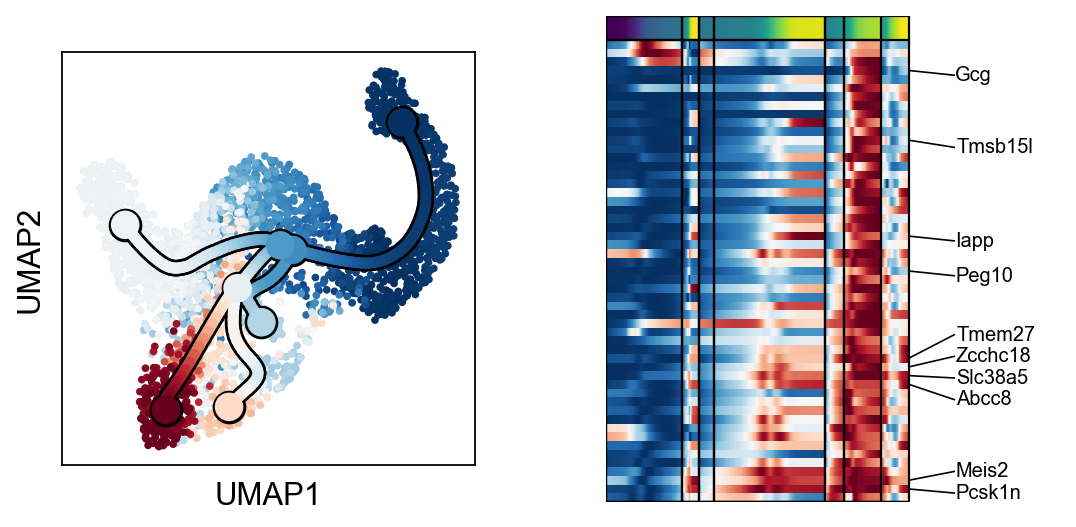

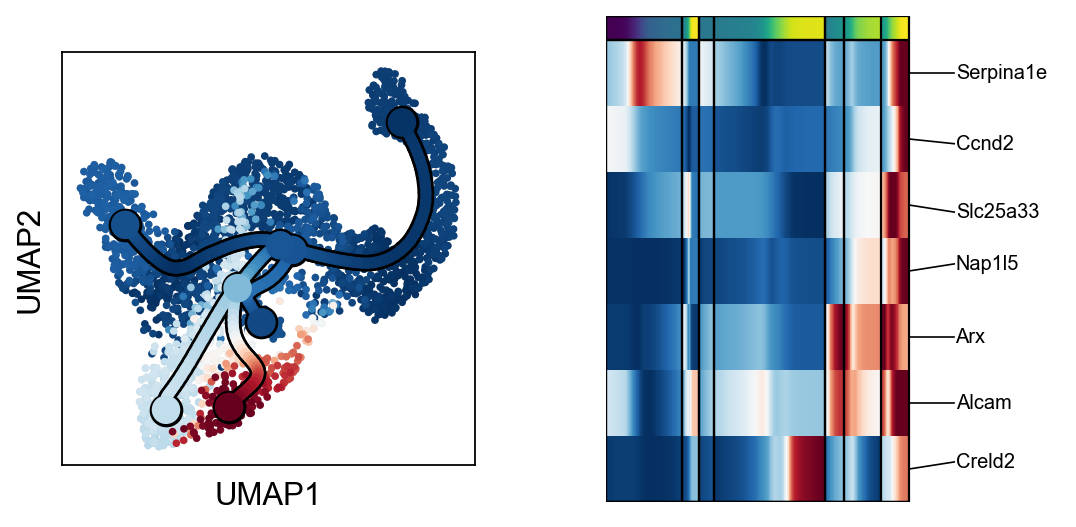

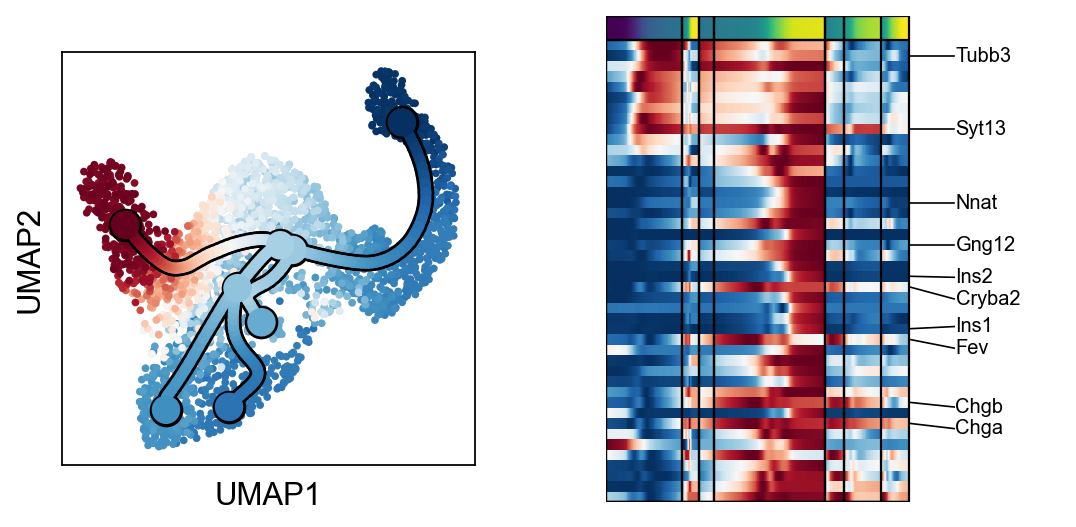

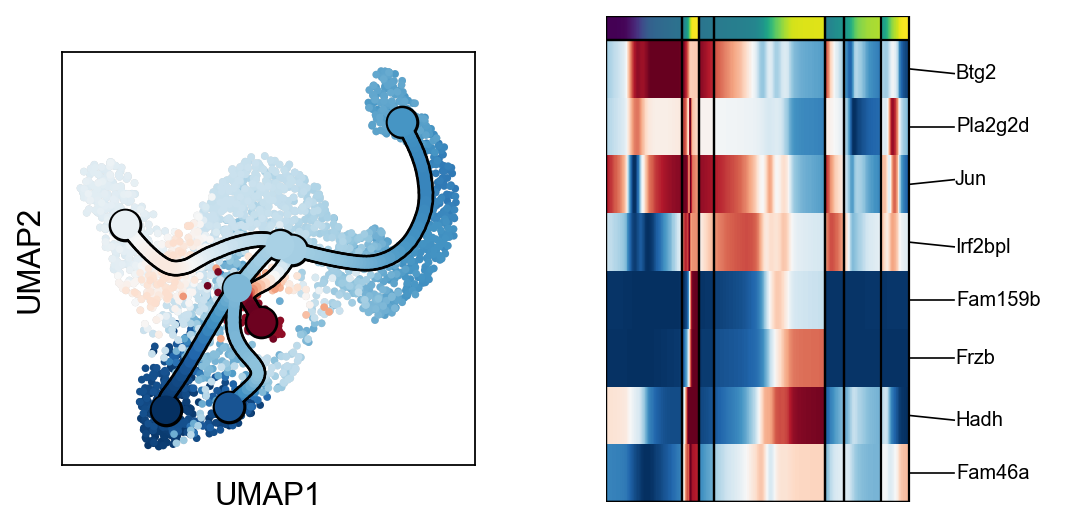

In [33]:
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category = MatplotlibDeprecationWarning)
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch=miles[0])
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch=miles[1])
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch=miles[2])
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch=miles[3])